### Code 


In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [12]:
! pip install scikit-learn --quiet
! pip install cython --quiet
! pip install h5py --quiet
!pip install wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 23.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.9 MB/s eta 0:00:00


In [3]:
!pip install pytorch_lightning --quiet
!pip install lightly --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.5/530.5 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 963.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 7.8 MB/s eta 0:00:00


In [4]:
import argparse
import pytorch_lightning as pl
import glob
import random
import numpy as np

from sklearn.svm import SVC
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import sys
sys.path.append('content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/')
from drive.MyDrive.CrossPoint_Sapienza_NN_2023.datasets.data import *
from drive.MyDrive.CrossPoint_Sapienza_NN_2023.datasets.plyfile import load_ply
from drive.MyDrive.CrossPoint_Sapienza_NN_2023.models.dgcnn import ResNet, DGCNN_partseg



## ❗️❗️❗️❗️ NOTE ❗️❗️❗️❗️
The last parameter of the following cell make sure to choose the pretrained model either from the checkpoints folder (if you trained the models) or from the 'models' folder (if you get just the pretrained one).

Be careful then to change the folder if you moved the model somewhere else.


In [64]:
parser = argparse.ArgumentParser(description='Point Cloud Recognition')
parser.add_argument('--num_points', type=int, default=1024, help='num of points to use')
parser.add_argument('--emb_dims', type=int, default=1024, metavar='N', help='Dimension of embeddings')
parser.add_argument('--k', type=int, default=15, metavar='N', help='Num of nearest neighbors to use')
parser.add_argument('--dropout', type=float, default=0.5, help='dropout rate')
parser.add_argument('--model_point', type=str, default='pct',choices=['dgcnn','pct'], help='Point feature extractor')

parser.add_argument('--from_ckpt', type=bool, default=True)

args = parser.parse_args("")

### Lightning DGCNN + knn & get_graph_feature

In [65]:
def knn(x, k):
    inner = -2*torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)
 
    idx = pairwise_distance.topk(k=k, dim=-1)[1]   # (batch_size, num_points, k)
    return idx


def get_graph_feature(x, k=20, idx=None):
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)
    if idx is None:
        idx = knn(x, k=k)   # (batch_size, num_points, k)

    
    #Mio commento----
    #device = torch.device('cuda:1')
    #----
    if (torch.cuda.is_available()):
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    #------

    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1)*num_points

    idx = idx + idx_base

    idx = idx.view(-1)
 
    _, num_dims, _ = x.size()

    x = x.transpose(2, 1).contiguous()   # (batch_size, num_points, num_dims)  -> (batch_size*num_points, num_dims) #   batch_size * num_points * k + range(0, batch_size*num_points)
    feature = x.view(batch_size*num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims) 
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    
    feature = torch.cat((feature-x, x), dim=3).permute(0, 3, 1, 2).contiguous()
  
    return feature

class DGCNN(pl.LightningModule):
    def __init__(self, args, cls = -1) -> None:
        super(DGCNN,self).__init__()
        self.k = args.k

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm1d(args.emb_dims)

        self.conv1 = nn.Sequential(nn.Conv2d(6, 64, kernel_size=1, bias=False),self.bn1, nn.LeakyReLU(negative_slope=0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(64*2, 64, kernel_size=1, bias=False),self.bn2,nn.LeakyReLU(negative_slope=0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(64*2, 128, kernel_size=1, bias=False),self.bn3,nn.LeakyReLU(negative_slope=0.2))
        self.conv4 = nn.Sequential(nn.Conv2d(128*2, 256, kernel_size=1, bias=False), self.bn4, nn.LeakyReLU(negative_slope=0.2))
        self.conv5 = nn.Sequential(nn.Conv1d(512, args.emb_dims, kernel_size=1, bias=False), self.bn5, nn.LeakyReLU(negative_slope=0.2))

        if cls != -1:
            self.linear1 = nn.Linear(args.emb_dims*2, 512, bias=False)
            self.bn6 = nn.BatchNorm1d(512)
            self.dp1 = nn.Dropout(p=args.dropout)
            self.linear2 = nn.Linear(512, 256)
            self.bn7 = nn.BatchNorm1d(256)
            self.dp2 = nn.Dropout(p=args.dropout)
            self.linear3 = nn.Linear(256, output_channels)
        
        self.cls = cls

        self.inv_head = nn.Sequential(
              nn.Linear(args.emb_dims * 2, args.emb_dims),
              nn.BatchNorm1d(args.emb_dims),
              nn.ReLU(inplace=True),
              nn.Linear(args.emb_dims, 256)
          )

    def forward(self, x):
        batch_size = x.size(0)
        x = get_graph_feature(x, k=self.k)
        x = self.conv1(x)
        x1 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x1, k=self.k)
        x = self.conv2(x)
        x2 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x2, k=self.k)
        x = self.conv3(x)
        x3 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x3, k=self.k)
        x = self.conv4(x)
        x4 = x.max(dim=-1, keepdim=False)[0]

        x = torch.cat((x1, x2, x3, x4), dim=1)

        x = self.conv5(x)
        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1)
        x = torch.cat((x1, x2), 1)
        
        feat = x
        if self.cls != -1:
            x = F.leaky_relu(self.bn6(self.linear1(x)), negative_slope=0.2)
            x = self.dp1(x)
            x = F.leaky_relu(self.bn7(self.linear2(x)), negative_slope=0.2)
            x = self.dp2(x)
            x = self.linear3(x)
        
        inv_feat = self.inv_head(feat)
        
        return x, inv_feat, feat 



### PointCloudTransformer (naive)

In [66]:
import math
def messingWithKeys():
  state_dict = torch.load(args['spct_model_path'])
  point_model = Pct()

  new_state_dict = {}
  not_desired_keys = ["module.cls.linear1.weight", "module.cls.linear2.weight", "module.cls.linear2.bias", "module.cls.bn1.weight", "module.cls.bn1.bias", "module.cls.bn1.running_mean", "module.cls.bn1.running_var", "module.cls.bn1.num_batches_tracked", "module.cls.bn2.weight", "module.cls.bn2.bias", "module.cls.bn2.running_mean", "module.cls.bn2.running_var", "module.cls.bn2.num_batches_tracked"]
  for k, v in state_dict.items():
      if k not in not_desired_keys:
        new_k = k.replace("module.encoder.", "")
        new_state_dict[new_k] = v

  point_model.load_state_dict(new_state_dict)
  return point_model

class Embedding(nn.Module):
    """
    Input Embedding layer which consist of 2 stacked LBR layer.
    """

    def __init__(self, in_channels=3, out_channels=128):
        super(Embedding, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=1, bias=False)

        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
    
    def forward(self, x):
        """
        Input
            x: [B, in_channels, N]
        
        Output
            x: [B, out_channels, N]
        """
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x


class SA(nn.Module):
    """
    Self Attention module.
    """

    def __init__(self, channels):
        super(SA, self).__init__()

        self.da = channels // 4

        self.q_conv = nn.Conv1d(channels, channels // 4, 1, bias=False)
        self.k_conv = nn.Conv1d(channels, channels // 4, 1, bias=False)
        self.q_conv.weight = self.k_conv.weight
        self.v_conv = nn.Conv1d(channels, channels, 1)
        
        self.trans_conv = nn.Conv1d(channels, channels, 1)
        self.after_norm = nn.BatchNorm1d(channels)
        
        self.act = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        """
        Input
            x: [B, de, N]
        
        Output
            x: [B, de, N]
        """
        # compute query, key and value matrix
        x_q = self.q_conv(x).permute(0, 2, 1)  # [B, N, da]
        x_k = self.k_conv(x)                   # [B, da, N]        
        x_v = self.v_conv(x)                   # [B, de, N]

        # compute attention map and scale, the sorfmax
        energy = torch.bmm(x_q, x_k) / (math.sqrt(self.da))   # [B, N, N]
        attention = self.softmax(energy)                      # [B, N, N]

        # weighted sum
        x_s = torch.bmm(x_v, attention)  # [B, de, N]
        x_s = self.act(self.after_norm(self.trans_conv(x_s)))
        
        # residual
        x = x + x_s

        return x

class Pct(pl.LightningModule):
    def __init__(self,args):
        super().__init__()
        self.args = args 

        self.embedding = Embedding(3, 128)

        self.sa1 = SA(128)
        self.sa2 = SA(128)
        self.sa3 = SA(128)
        self.sa4 = SA(128)

        self.linear = nn.Sequential(
            nn.Conv1d(512, 1024, kernel_size=1, bias=False),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.2)
        )
      
        self.inv_head = nn.Sequential(
            nn.Linear(args.emb_dims * 2, args.emb_dims),
            nn.BatchNorm1d(args.emb_dims),
            nn.ReLU(inplace=True),
            nn.Linear(args.emb_dims, 256)
        )

       
    def forward(self, x):
        batch_size = x.size(0)

        x = self.embedding(x) #x shape->torch.Size([2bs, 3, 2048])
        
        x1 = self.sa1(x) #x1 shape->torch.Size([2bs, 128, 2048])
        x2 = self.sa2(x1) #x2 shape->torch.Size([2bs, 128, 2048])
        x3 = self.sa3(x2) #x3 shape->torch.Size([2bs, 128, 2048])
        x4 = self.sa4(x3) #x4 shape->torch.Size([2bs, 128, 2048])
        x = torch.cat([x1, x2, x3, x4], dim=1) #x shape after cat->torch.Size([2bs, 512, 2048])

        x = self.linear(x) #x shape after linear->torch.Size([2bs, 1024, 2048])
    
        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1) # 2bs,1024
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1) # 2bs,1024
        x = torch.cat((x1, x2), 1) # 2bs,2048
        feat = x
        inv_feat = self.inv_head(feat) # torch.Size([2bs, 256])

        x_max = torch.max(x, dim=-1)[0]
        x_mean = torch.mean(x, dim=-1)

        return inv_feat, x_max, x_mean, feat


### Configurations


In [169]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
    print("Flying on GPU")
else:
    device = torch.device("cpu")
    print("Morendo on CPU")


print("Please select a point cloud feature extractor trained with the combinationations options from the menu below:")
print("1. DGCNN + ResNet")
print("2. DGCNN + Vision Transformer")
print("3. PCT + ResNet")
print("4. PCT + Vision Transformer")

if args.from_ckpt == True:
  BASE_DIR = '/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/checkpoints'
else:
  BASE_DIR = '/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/pretrained'

choice = int(input("Enter your choice (1-4): "))
while choice not in range(1, 5):
    print("Invalid choice. Please enter a number between 1 and 4.")
    choice = int(input("Enter your choice (1-4): "))


if choice == 1:
    print("You selected DGCNN + ResNet.")
    path_model = BASE_DIR+'/DGCNN+ResNet/models/best_modeldgcnn.pth'
    net_self = torch.load(path_model,map_location=device)
    model_self = DGCNN(args)
    exp_name = "DGCNN + ResNet"
    args.model_point = "dgcnn"
    
elif choice == 2:
    print("You selected DGCNN + Vision Transformer.")
    path_model = BASE_DIR+'/DGCNN+VisionTransformer/models/best_modeldgcnn.pth'
    net_self = torch.load(path_model,map_location=device)
    model_self = DGCNN(args)
    exp_name = "DGCNN + Vision Transfomer"
    args.model_point = "dgcnn"

elif choice == 3:
    print("You selected PCT + ResNet.")
    path_model = BASE_DIR+'/PCT+ResNet/models/best_modelpct.pth'
    net_self = torch.load(path_model,map_location=device)
    model_self = Pct(args)
    exp_name = "PCT + ResNet"
    args.model_point = "pct"


elif choice == 4:
    print("You selected PCT + Vision Transformer.")
    path_model = BASE_DIR+'/PCT+VisionTransformer/models/best_modelpct.pth'
    net_self = torch.load(path_model,map_location=device)
    model_self = Pct(args)
    exp_name = "PCT + Vision Transfomer"
    args.model_point = "pct"


model_self.load_state_dict(net_self)

Flying on GPU
Please select a point cloud feature extractor trained with the combinationations options from the menu below:
1. DGCNN + ResNet
2. DGCNN + Vision Transformer
3. PCT + ResNet
4. PCT + Vision Transformer
Enter your choice (1-4): 4
You selected PCT + Vision Transformer.


<All keys matched successfully>

### Choose the dataset

In [179]:
# Choose Dataset ["ModelNet40, ScanObjectNN"]
dataset = "ScanObjectNN" 

In [180]:
#ModelNet
if dataset == 'ModelNet40':
  train_loader = DataLoader(ModelNet40SVM(partition='train', num_points=args.num_points),batch_size=10, shuffle=True)
  test_loader = DataLoader(ModelNet40SVM(partition='test', num_points=args.num_points),batch_size=2, shuffle=True)
  print('Done ModelNet!!')
elif dataset == 'ScanObjectNN':
  #ScanObj
  train_loader = DataLoader(ScanObjectNNSVM(partition='train', num_points=args.num_points), batch_size=10, shuffle=True)
  test_loader = DataLoader(ScanObjectNNSVM(partition='test', num_points=args.num_points), batch_size=2, shuffle=True)
  print('Done ScanObject!!')

Done ScanObject!!


### Load Train Feats

In [181]:
import random

feats_train = []
labels_train = []
model = model_self.to(device)
model = model.eval()


for i, (data, label) in enumerate(train_loader):
    if dataset == "ModelNet40":
        #labels = list(map(lambda x: x[0],label.numpy().tolist()))
        labels = list(map(lambda x: [x], label.numpy().tolist()))
    elif dataset == "ScanObjectNN":
        labels = label.numpy().tolist()
    data = data.permute(0, 2, 1).to(device)
    with torch.no_grad():
        if args.model_point == 'dgcnn':
          feats = model(data)[2]
        elif args.model_point == 'pct':
          feats = model(data)[3]
        else:
          raise ("Not implemented")

    feats = feats.detach().cpu().numpy()
    for feat in feats:
        feats_train.append(feat)
    labels_train += labels

feats_train = np.array(feats_train)
labels_train = np.array(labels_train)

### Load Test Feats

In [182]:
import random

feats_test = []
labels_test = []
model = model_self.to(device)
model = model.eval()

for i, (data, label) in enumerate(test_loader):
    if dataset == "ModelNet40":
        #labels = list(map(lambda x: x[0],label.numpy().tolist()))
        labels = list(map(lambda x: [x], label.numpy().tolist()))
    elif dataset == "ScanObjectNN":
        labels = label.numpy().tolist()
    data = data.permute(0, 2, 1).to(device)
    with torch.no_grad():
          if args.model_point == 'dgcnn':
            feats = model(data)[2]
          elif args.model_point == 'pct':
            feats = model(data)[3]
          else:
            raise ("Not implemented")
    feats = feats.detach().cpu().numpy()
    for feat in feats:
        feats_test.append(feat)
    # labels_train.append(label)
    labels_test += labels

feats_test = np.array(feats_test)
labels_test = np.array(labels_test)
feats_test.shape

(581, 2048)

### Train Linear Model

In [183]:
c = 0.01 # Linear SVM parameter C, can be tuned
model_tl = SVC(C = c, kernel ='linear')
if dataset == 'ModelNet40':
  model_tl.fit(feats_train, labels_train.reshape(-1,1))
elif dataset == 'ScanObjectNN':
  model_tl.fit(feats_train, labels_train)

### Evaluation


In [184]:
if dataset == 'ModelNet40':
  objects = ["airplane", "bathtub", "bed", "bench", "bookshelf", "bottle", "bowl", "car", "chair", "cone", "cup", "curtain", "desk", "door", "dresser", "flower_pot", "glass_box", "guitar", "keyboard", "lamp", "laptop", "mantel", "monitor", "night_stand", "person", "piano", "plant", "radio", "range_hood", "sink", "sofa", "stairs", "stool", "table", "tent", "toilet", "tv_stand", "vase", "wardrobe", "xbox"]

  mapping = {}
  for i, obj in enumerate(objects):
      mapping[i] = obj
      
elif dataset == 'ScanObjectNN':
  mapping = {0: "bag", 1: "bin", 2: "box", 3: "cabinet", 4: "chair", 5: "desk", 6: "display", 7: "door", 8: "shelf", 9: "table", 10: "bed", 11: "pillow", 12: "sink", 13: "sofa", 14: "toilet"}
  
classes_labels = [mapping[i] for i in np.unique(labels_train)]

In [156]:
print(classes_labels)

['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone', 'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp', 'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink', 'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']


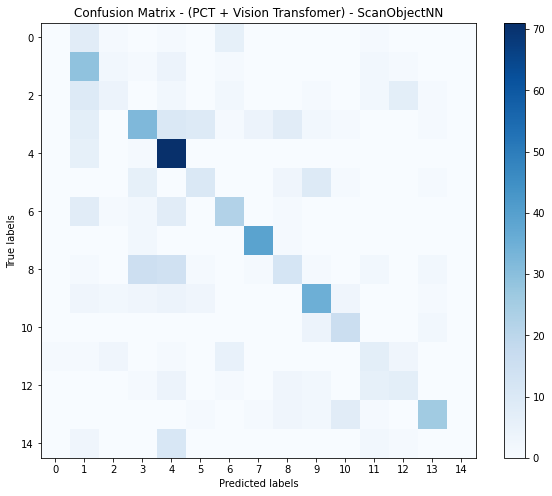

In [185]:
# Compute the confusion matrix
y_pred = model_tl.predict(feats_test)
if dataset == 'ModelNet40':
  cm = confusion_matrix(labels_test.reshape(-1,1), y_pred)
elif dataset == 'ScanObjectNN':
  cm = confusion_matrix(labels_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - (" + exp_name + ') - ' + dataset)
plt.xticks(np.arange(len(classes_labels)))
plt.show()

In [186]:
if dataset == 'ModelNet40':
  print(f"Experiment = {exp_name} Dataset = {dataset} : Accuracy = {model_tl.score(feats_test, labels_test.reshape(-1,1))}")
elif dataset == 'ScanObjectNN':
  print(f"Experiment = {exp_name} Dataset = {dataset} : Accuracy = {model_tl.score(feats_test, labels_test)}")

Experiment = PCT + Vision Transfomer Dataset = ScanObjectNN : Accuracy = 0.5335628227194492


In [187]:
# initialize wandb
import wandb
wandb.init(project='CrossPoint')


# log the accuracy to wandb
wandb.run.name = exp_name+"-"+dataset
if dataset == 'ModelNet40':
  wandb.log({"Test Accuracy "+exp_name+"-"+dataset: model_tl.score(feats_test, labels_test.reshape(-1,1))})
elif dataset == 'ScanObjectNN':
  wandb.log({"Test Accuracy "+exp_name+"-"+dataset: model_tl.score(feats_test, labels_test)})


# finalize the wandb run
wandb.join()

Test Accuracy PCT + Vision Transfomer-ScanObjectNN,▁
Test Accuracy PCT + Vision Transfomer-ScanObjectNN,0.53356
